In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2025-05-30 16:25:47.770570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_mfcc(mfcc, fs):
    plt.figure(figsize=(12,6))    
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
    plt.title('MFCCs')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()


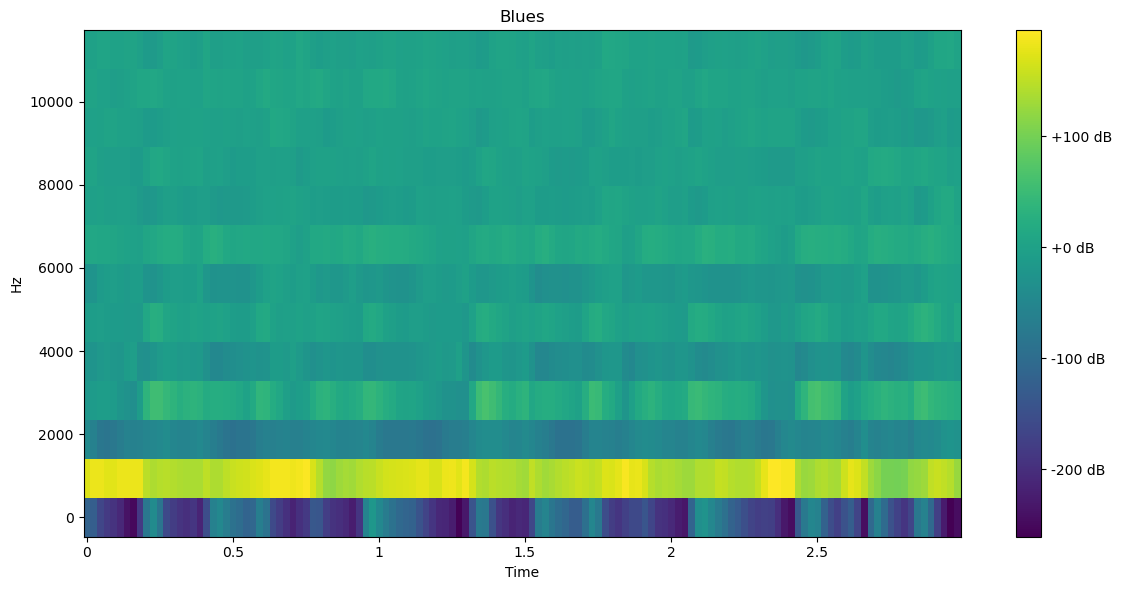

In [3]:
path_prefix = "/home/efectn/python-music-classification"
feature_path = os.path.join(path_prefix, "dataset/features_3.0_sec.json")
with open(feature_path, "r") as fp:
    data = json.load(fp)
    
idx = 100
fs = 22500
plot_mfcc(np.array(data["mfcc"])[idx].T, fs)
plt.title(f"{np.array(data['genre_name'])[idx].title()}");


In [4]:
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

def plot_history(hist):
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

def make_prediction(model, X):
    global genres
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1)
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])
        
    return preds_num, preds_name


X training data shape: (5593, 132, 13), y training data shape: (5593,)
X validation data shape: (1399, 132, 13), y validation data shape: (1399,)


In [5]:
model_dnn = Sequential()

model_dnn.add(Flatten(input_shape=(X.shape[1:3])))

model_dnn.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(10, activation='softmax'))

model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1716)              0         
                                                                 
 dense (Dense)               (None, 512)               879104    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

2025-05-30 16:26:17.164227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
callbacks = [
             EarlyStopping(patience=10)
]

model_dnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

hist_dnn = model_dnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=250,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/250
88/88 [==============================] - 1s 7ms/step - loss: 32.8857 - acc: 0.1230 - val_loss: 4.0242 - val_acc: 0.1594
Epoch 2/250
88/88 [==============================] - 0s 5ms/step - loss: 10.0138 - acc: 0.1387 - val_loss: 3.5512 - val_acc: 0.0779
Epoch 3/250
88/88 [==============================] - 0s 5ms/step - loss: 6.0312 - acc: 0.1069 - val_loss: 3.5245 - val_acc: 0.0922
Epoch 4/250
88/88 [==============================] - 0s 5ms/step - loss: 4.6748 - acc: 0.0991 - val_loss: 3.5186 - val_acc: 0.1022
Epoch 5/250
88/88 [==============================] - 1s 6ms/step - loss: 4.1252 - acc: 0.1126 - val_loss: 3.5156 - val_acc: 0.1029
Epoch 6/250
88/88 [==============================] - 1s 7ms/step - loss: 3.9068 - acc: 0.1216 - val_loss: 3.5148 - val_acc: 0.1022
Epoch 7/250
88/88 [==============================] - 0s 6ms/step - loss: 3.8518 - acc: 0.1137 - val_loss: 3.5132 - val_acc: 0.1015
Epoch 8/250
88/88 [==============================] - 0s 5ms/step - loss: 3.7396 -

94/94 [==============================] - 0s 1ms/step - loss: 1.9428 - acc: 0.5596
Test Loss: 1.9428203105926514
Test Accuracy: 0.5595595836639404


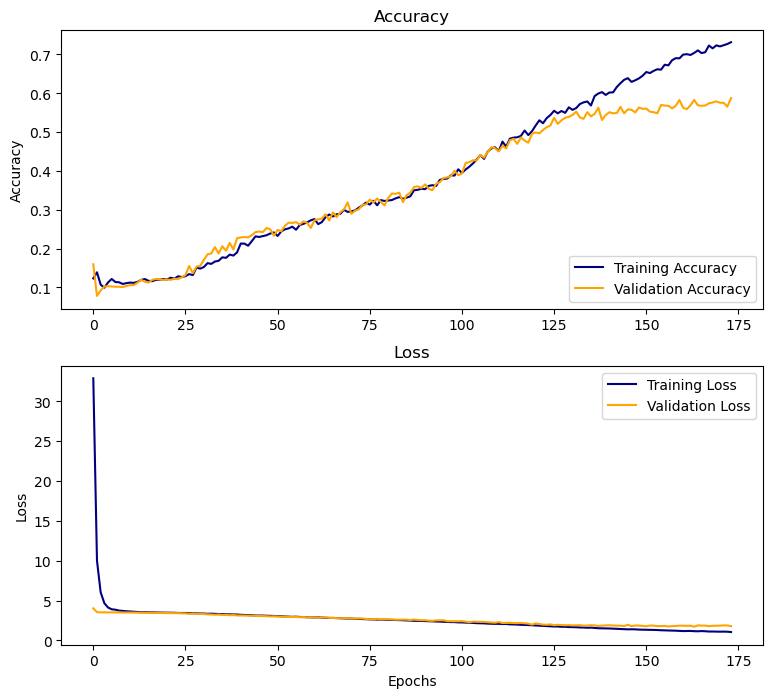

In [7]:
loss_dnn, acc_dnn = model_dnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss_dnn}")
print(f"Test Accuracy: {acc_dnn}")
plot_history(hist_dnn)

In [8]:
preds_num, preds_name = make_prediction(model_dnn, X_test)

1/1 [==============================] - 0s 14ms/step


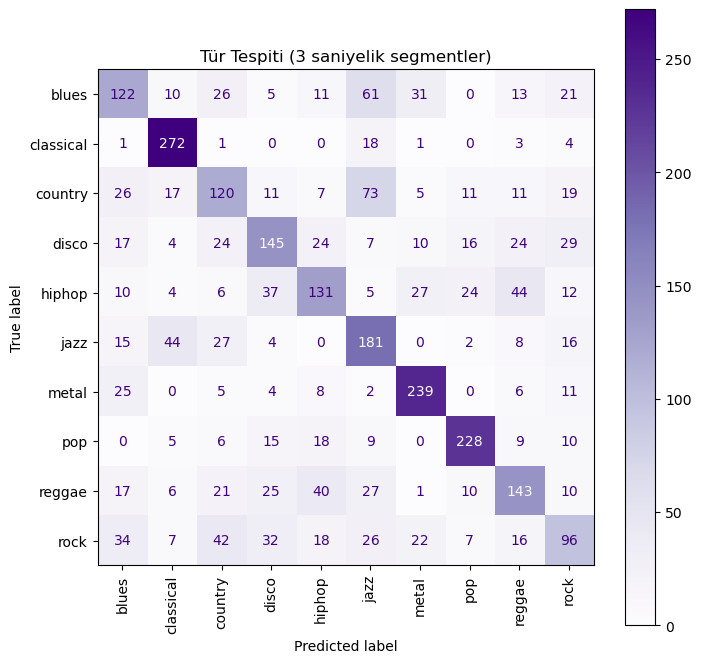

In [13]:
cm = confusion_matrix(y_test, preds_num)

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Tür Tespiti (3 saniyelik segmentler)');


In [12]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report

def evaluate_model(model, X, y_true):
    global genres
    # Tahminleri al
    preds_num, _ = make_prediction(model, X)

    # Genel skorlar
    accuracy = accuracy_score(y_true, preds_num)
    precision_macro = precision_score(y_true, preds_num, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, preds_num, average='weighted', zero_division=0)
    f1_macro = f1_score(y_true, preds_num, average='macro')
    f1_weighted = f1_score(y_true, preds_num, average='weighted')

    # Genel sonuçları yazdır
    print("🔹 Genel Performans:")
    print(f"Accuracy               : {accuracy:.4f}")
    print(f"Precision (macro)      : {precision_macro:.4f}")
    print(f"Precision (weighted)   : {precision_weighted:.4f}")
    print(f"F1 Score (macro)       : {f1_macro:.4f}")
    print(f"F1 Score (weighted)    : {f1_weighted:.4f}")

    # Sınıf bazlı skorlar
    print("\n🔹 Tür Bazlı Performans (Precision, Recall, F1):")
    report = classification_report(y_true, preds_num, target_names=genres, zero_division=0)
    print(report)

    # Dictionary olarak da döndür
    return classification_report(y_true, preds_num, target_names=genres, output_dict=True, zero_division=0)


metrics = evaluate_model(model_dnn, X_test, y_test)

1/1 [==============================] - 0s 15ms/step
🔹 Genel Performans:
Accuracy               : 0.5596
Precision (macro)      : 0.5513
Precision (weighted)   : 0.5514
F1 Score (macro)       : 0.5517
F1 Score (weighted)    : 0.5517

🔹 Tür Bazlı Performans (Precision, Recall, F1):
              precision    recall  f1-score   support

       blues       0.46      0.41      0.43       300
   classical       0.74      0.91      0.81       300
     country       0.43      0.40      0.42       300
       disco       0.52      0.48      0.50       300
      hiphop       0.51      0.44      0.47       300
        jazz       0.44      0.61      0.51       297
       metal       0.71      0.80      0.75       300
         pop       0.77      0.76      0.76       300
      reggae       0.52      0.48      0.50       300
        rock       0.42      0.32      0.36       300

    accuracy                           0.56      2997
   macro avg       0.55      0.56      0.55      2997
weighted avg   

In [10]:
model_dnn.save(os.path.join(path_prefix, "models/model_dnn.h5"))
model_dnn.save(os.path.join(path_prefix, "models/model_dnn.keras"), save_format="keras")